In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [4]:
# load dataset
basedir = os.getcwd()
data_basedir = os.path.join(basedir,'classification_data_HWK1')
trainA_path = os.path.join(data_basedir,'classificationA.train')
testA_path = os.path.join(data_basedir,'classificationA.test')
trainB_path = os.path.join(data_basedir,'classificationB.train')
testB_path = os.path.join(data_basedir,'classificationB.test')
trainC_path = os.path.join(data_basedir,'classificationC.train')
testC_path = os.path.join(data_basedir,'classificationC.test')

trainA = np.loadtxt(trainA_path,delimiter='\t')
testA = np.loadtxt(testA_path,delimiter='\t')
trainB = np.loadtxt(trainB_path,delimiter='\t')
testB = np.loadtxt(testB_path,delimiter='\t')
trainC = np.loadtxt(trainC_path,delimiter='\t')
testC = np.loadtxt(testC_path,delimiter='\t')

## LDA

In [8]:
def LDA(data_train):
    """
    return the parameters w, c, the predicted results and errors
    mu.shape=(1,p)
    cov.shape=(p,p)   
    """
    # calculate mean and covariance matrix
    n = data_train.shape[0]
    n1 = np.sum(data_train[:,2])
    n0 = n - n1
    pi = n1 / n
    X1 = data_train[data_train[:,2]==1,:2]
    X0 = data_train[data_train[:,2]==0,:2]
    mu1 = np.sum(X1,axis=0) / n1
    mu0 = np.sum(X0,axis=0) / n0
    X1 -= mu1
    X0 -=mu0
    X = np.concatenate((X1,X0),axis=0)
    cov_tsp = np.linalg.inv(np.dot(X.T,X.conj())/n)
    # w , c
    w = np.dot(cov_tsp,(mu1-mu0).transpose())
    c = np.log(pi/(1-pi))-0.5*np.dot(np.dot(mu1,cov_tsp),mu1.transpose())+0.5*np.dot(np.dot(mu0,cov_tsp),mu0.transpose())   
    return w,c

def LDA_predict(w,c,data_test):
    # predict
    x = data_test[:,:2]
    y = data_test[:,2][:,np.newaxis]
    prediction = np.dot(x,w)+c
    prediction = prediction[:,np.newaxis]
    prediction[prediction>0] = 1
    prediction[prediction<=0] = 0
    misspercent = np.sum(np.abs(y-prediction))/y.shape[0]
    return misspercent
    
     
def point_cloud(data,w,c,line_xrange):
    plt.clf()
    data0 = data[data[:,2]==0]
    data1 = data[data[:,2]==1]
    plt.figure(figsize=(6,4))
    # cloud of points
    plt.plot(data0[:,0],data0[:,1],'x', label='Class 0')
    plt.plot(data1[:,0],data1[:,1],'x', label='Class 1')
    # the line p(y=1|x)=0.5
    xline = np.linspace(line_xrange[0],line_xrange[1], num=100)
    yline = (-w[0]*xline - c)/w[1]
    plt.plot(xline,yline,'.', label='p(y=1|x)=0.5')
    plt.axis('equal')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(loc=1)
    plt.show()

[-2.05129911 -0.27311529] 0.11242913217698458


<Figure size 432x288 with 0 Axes>

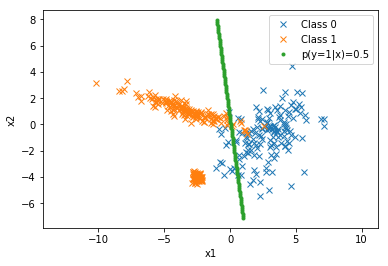

In [9]:
w,c = LDA(trainC)
print(w,c)
point_cloud(trainC,w,c,(-1,1))

## Logistic regression

In [5]:
def sigmoid(w,x):
    """
    x.shape=(n,p)
    y.shape=(n,1)
    w.shape=(p,1)
    return.shape=(n,1)
    """
    alpha = np.dot(x,w)
    return 1.0/(1.0+np.exp(-alpha))

def log_l(x,y,w):
    """
    return is a number
    """
    sigmoid_tp = sigmoid(w,x)
    log_likelihood =  np.sum(y * np.log(sigmoid_tp) + (1 - y) * np.log(1 - sigmoid_tp))
    return log_likelihood

def gradient_logl(x,y,w):
    """
    x.shape=(n,p)
    y.shape=(n,1)
    w.shape=(p,1)
    return.shape=(p,1)
    """
    sigmoid_tp = sigmoid(w,x)
    gradient = np.sum((y - sigmoid_tp)*x,axis=0)[:,np.newaxis]
    return gradient

def hessian_logl(x,y,w):
    """
    x.shape=(n,p)
    y.shape=(n,1)
    w.shape=(p,1)
    return.shape=(p,p)
    """
    sigmoid_tp = sigmoid(w,x)  
    sigmoid_part = (sigmoid_tp * (1 - sigmoid_tp))
    par_part = np.einsum('ki,kl->kil',x,x)
    hessian = -np.sum(np.einsum('kij,kl->kij',par_part,sigmoid_part),axis=0) 
    return hessian
                      
def LogisticRegression_newton(data_train):
    x = data_train[:,:2]
    y = data_train[:,2][:,np.newaxis]   
    # first turn w_T*x+b ==> wx
    ones_tp = np.ones((x.shape[0],1))
    X = np.concatenate((x,ones_tp), axis=1)
    # set initial values
    i = 0
    w = np.array([[-2.0,-0.1,0.1]]).transpose()
    logl = log_l(X,y,w)
    incre_l = 1000000
    # convergence condition
    delta = 0.000001
    max_iter = 2000
    
    while abs(incre_l) > delta and i < max_iter:
        i += 1
        g = gradient_logl(X,y,w)
        h = hessian_logl(X,y,w)
        w -= np.dot(np.linalg.inv(h),g)
        logl_update = log_l(X,y,w)
        incre_l = logl_update - logl
        logl = logl_update
        return w
    
def LogisticRegression_predict(w,data_test):
    # predict
    x = data_test[:,:2]
    # first turn w_T*x+b ==> wx
    ones_tp = np.ones((x.shape[0],1))
    X = np.concatenate((x,ones_tp), axis=1)
    y = data_test[:,2][:,np.newaxis]
    
    prediction = np.dot(X,w)
    prediction[prediction>0] = 1
    prediction[prediction<=0] = 0
    misspercent = np.sum(np.abs(y-prediction))/y.shape[0]
    return misspercent

[-1.55526264  0.74889279] 0.8028973663309293


<Figure size 432x288 with 0 Axes>

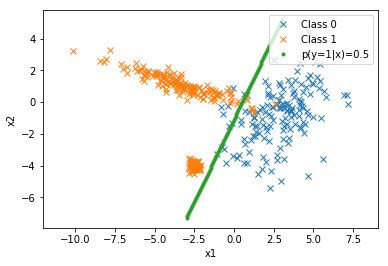

In [10]:
weights = LogisticRegression_newton(trainC)
w = weights[:2,0]
c = weights[2][0]
print(w,c)
point_cloud(trainC,w,c,(-3,3))

## Linear regression

In [6]:
def LinearRegression(data_train):
    x = data_train[:,:2]
    y = data_train[:,2][:,np.newaxis] 
    # first turn w_T*x+b ==> wx
    ones_tp = np.ones((x.shape[0],1))
    X = np.concatenate((x,ones_tp), axis=1)
    sym_mat = np.linalg.inv(np.dot(X.transpose(),X))
    w = np.dot(np.dot(sym_mat,X.transpose()),y)
    return w

def LinearRegression_predict(w,data_test):
    # predict
    x = data_test[:,:2]
    # first turn w_T*x+b ==> wx
    ones_tp = np.ones((x.shape[0],1))
    X = np.concatenate((x,ones_tp), axis=1)
    y = data_test[:,2][:,np.newaxis]  
    prediction = np.dot(X,w)
    prediction[prediction>0.5] = 1
    prediction[prediction<=0.5] = 0
    misspercent = np.sum(np.abs(y-prediction))/y.shape[0]
    return misspercent

[[-0.12769333]
 [-0.01700142]
 [ 0.50839982]]
[-0.12769333 -0.01700142] 0.008399815826348966


<Figure size 432x288 with 0 Axes>

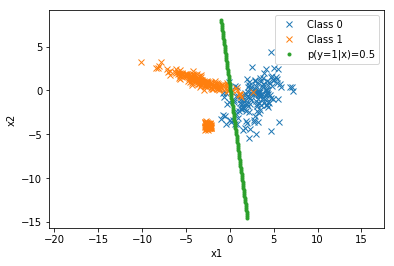

In [11]:
weights = LinearRegression(trainC)
print(weights)
w = weights[:2,0]
c = weights[2][0]-0.5
print(w,c)
point_cloud(trainC,w,c,(-1,2))

## Compare different models on the data

train error
             A         B      C
LDA   0.013333  0.030000  0.055
LogR  0.006667  0.193333  0.035
LinR  0.013333  0.030000  0.055
-----------------
test error
             A       B         C
LDA   0.020000  0.0415  0.042333
LogR  0.021333  0.1770  0.022000
LinR  0.020667  0.0415  0.042333


<Figure size 432x288 with 0 Axes>

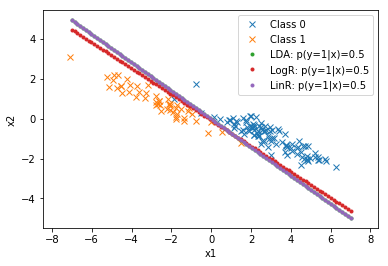

<Figure size 432x288 with 0 Axes>

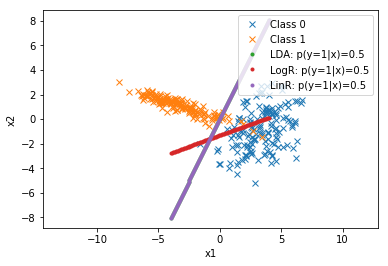

<Figure size 432x288 with 0 Axes>

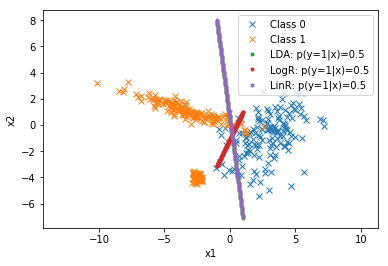

In [16]:
# missclassification errors
error_train=[]
error_test=[]
# LDA
wA,cA = LDA(trainA)
wB,cB = LDA(trainB)
wC,cC = LDA(trainC)
error_train.append([LDA_predict(wA,cA,trainA),LDA_predict(wB,cB,trainB),LDA_predict(wC,cC,trainC)])
error_test.append([LDA_predict(wA,cA,testA),LDA_predict(wB,cB,testB),LDA_predict(wC,cC,testC)])
# Logistic Regression
wA1 = LogisticRegression_newton(trainA)
wB1 = LogisticRegression_newton(trainB)
wC1 = LogisticRegression_newton(trainC)
error_train.append([LogisticRegression_predict(wA1,trainA),LogisticRegression_predict(wB1,trainB),LogisticRegression_predict(wC1,trainC)])
error_test.append([LogisticRegression_predict(wA1,testA),LogisticRegression_predict(wB1,testB),LogisticRegression_predict(wC1,testC)])
# Linear Regression
wA2= LinearRegression(trainA)
wB2= LinearRegression(trainB)
wC2= LinearRegression(trainC)
error_train.append([LinearRegression_predict(wA2,trainA),LinearRegression_predict(wB2,trainB),LinearRegression_predict(wC2,trainC)])
error_test.append([LinearRegression_predict(wA2,testA),LinearRegression_predict(wB2,testB),LinearRegression_predict(wC2,testC)])
# print
error_train = pd.DataFrame(error_train,columns=['A','B','C'],index=['LDA','LogR','LinR'])
error_test = pd.DataFrame(error_test,columns=['A','B','C'],index=['LDA','LogR','LinR'])
print('train error')
print(error_train)
print('-----------------')
print('test error')
print(error_test)

# visualization of cloud of points
def compare_cloud(data,wLDA,cLDA,wLogR,wLinR,line_xrange):
    plt.clf()
    data0 = data[data[:,2]==0]
    data1 = data[data[:,2]==1]
    plt.figure(figsize=(6,4))
    # cloud of points
    plt.plot(data0[:,0],data0[:,1],'x', label='Class 0')
    plt.plot(data1[:,0],data1[:,1],'x', label='Class 1')
    # the line p(y=1|x)=0.5
    xline = np.linspace(line_xrange[0],line_xrange[1], num=100)
    yline = (-wLDA[0]*xline - cLDA)/wLDA[1]
    plt.plot(xline,yline,'.', label='LDA: p(y=1|x)=0.5')
    
    xline = np.linspace(line_xrange[0],line_xrange[1], num=100)
    yline = (-wLogR[0][0]*xline - wLogR[2][0])/wLogR[1][0]
    plt.plot(xline,yline,'.', label='LogR: p(y=1|x)=0.5')
    
    xline = np.linspace(line_xrange[0],line_xrange[1], num=100)
    yline = (-wLinR[0][0]*xline - wLinR[2][0]+0.5)/wLinR[1][0]
    plt.plot(xline,yline,'.', label='LinR: p(y=1|x)=0.5')
    
    plt.axis('equal')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(loc=1)
    plt.show()
compare_cloud(trainA,wA,cA,wA1,wA2,(-7,7))
compare_cloud(trainB,wB,cB,wB1,wB2,(-4,4))
compare_cloud(trainC,wC,cC,wC1,wC2,(-1,1))

## QDA model

In [31]:
def QDA(data_train):
    """
    return the parameters w, c, the predicted results and errors
    mu.shape=(1,p)
    cov.shape=(p,p)   
    """
    # calculate mean and covariance matrix
    n = data_train.shape[0]
    n1 = np.sum(data_train[:,2])
    n0 = n - n1
    pi = n1 / n
    X1 = data_train[data_train[:,2]==1,:2]
    X0 = data_train[data_train[:,2]==0,:2]
    mu1 = np.sum(X1,axis=0) / n1
    mu0 = np.sum(X0,axis=0) / n0
    X1 -= mu1
    X0 -=mu0
    cov1 = np.dot(X1.T,X1.conj())/n
    cov0 = np.dot(X0.T,X0.conj())/n
    cov_tsp1 = np.linalg.inv(cov1)
    cov_tsp0 = np.linalg.inv(cov0)
    # c
    c1 = np.log(pi/np.sqrt(np.linalg.det(cov1)))
    c0 = np.log((1-pi)/np.sqrt(np.linalg.det(cov0)))  
    return mu1,mu0,cov_tsp1,cov_tsp0,c1,c0

def QDA_predict(mu1,mu0,cov_tsp1,cov_tsp0,c1,c0,data_test):
    def atba(a,b):
        """
        a.shape = (n,p,1)
        b.shape = (p,p)
        return.shape=(n,1)
        """
        tp = np.einsum('kij,il->klj',a,b)
        return np.einsum('kij,kij->kj',tp,a)
    # predict
    x = data_test[:,:2]
    Xcenter1 = x - mu1
    Xcenter0 = x - mu0
    C1 = c1*np.ones((data_test.shape[0],1))
    C0 = c0*np.ones((data_test.shape[0],1))
    prediction = C1-C0-0.5*atba(Xcenter1[:,:,np.newaxis],cov_tsp1)+0.5*atba(Xcenter0[:,:,np.newaxis],cov_tsp0)   
    prediction[prediction>0] = 1
    prediction[prediction<=0] = 0
    
    if data_test.shape[1]==3:
        y = data_test[:,2][:,np.newaxis]
        misspercent = np.sum(np.abs(y-prediction))/y.shape[0]
    else:
        misspercent = -1
    return misspercent,prediction
    
     
def point_cloud(data,mu1,mu0,cov_tsp1,cov_tsp0,c1,c0):
    plt.clf()
    data0 = data[data[:,2]==0]
    data1 = data[data[:,2]==1]
    plt.figure(figsize=(6,4))
    # cloud of points
    plt.plot(data0[:,0],data0[:,1],'x', label='Class 0')
    plt.plot(data1[:,0],data1[:,1],'x', label='Class 1')
    # the curve p(y=1|x)=0.5
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    data_input = np.c_[xx.ravel(), yy.ravel()]
    useless,Z = QDA_predict(mu1,mu0,cov_tsp1,cov_tsp0,c1,c0,data_input)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired,label='p(y=1|x)=0.5')
    plt.axis('equal')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(loc=1)
    plt.show()
    
    

//anaconda/lib/python3.5/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)


<Figure size 432x288 with 0 Axes>

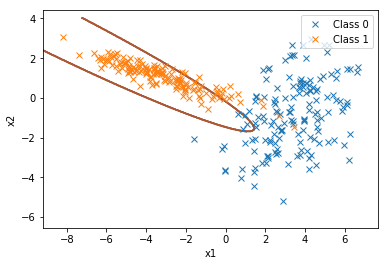

<Figure size 432x288 with 0 Axes>

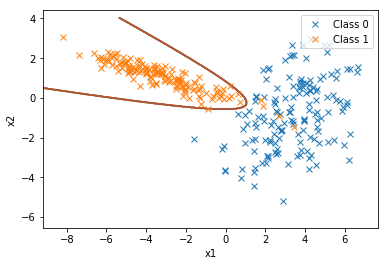

<Figure size 432x288 with 0 Axes>

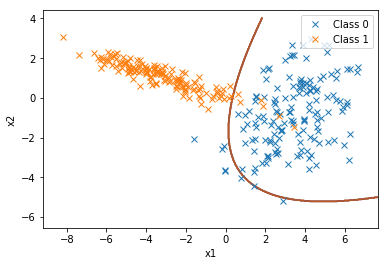

In [32]:
mu1,mu0,cov_tsp1,cov_tsp0,c1,c0 = QDA(trainA)
point_cloud(trainB,mu1,mu0,cov_tsp1,cov_tsp0,c1,c0)
mu1,mu0,cov_tsp1,cov_tsp0,c1,c0 = QDA(trainB)
point_cloud(trainB,mu1,mu0,cov_tsp1,cov_tsp0,c1,c0)
mu1,mu0,cov_tsp1,cov_tsp0,c1,c0 = QDA(trainC)
point_cloud(trainB,mu1,mu0,cov_tsp1,cov_tsp0,c1,c0)